# CCSC SSL Analysis

## Load data and dependencies

In [10]:
%load_ext autoreload
%autoreload 2

# load dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import preprocessing, metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import set_config

from utils.dataset import DataFactory
from utils.experiments import exp_endoscopist_specific, exp_endoscopist_agnostic

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('seaborn')
plt.style.use('seaborn-white')
plt.style.use('seaborn-paper')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data = DataFactory('ssl').load('data/ccsc-clean-ssl.csv')

## Explore data

In [3]:
#explore data
pd.options.display.max_columns = None
data.df.head()

,pt_sex,pt_age,pt_diabetic,pt_fit,risk_avg,risk_fhx,risk_polyp,risk_ca,doc_id,doc_spec,doc_train,proc_year,proc_servdate,proc_wt,proc_wt6,proc_diff,prep_poor,path_polyps,path_adenoma,path_adv_ad,path_ser,path_hp,path_ssl,path_tsa,path_ser_size,path_ser_loc_r,path_ser_loc_l,path_ser_number,path_ser_lgd,path_ser_hgd
0,1,61,0,0,1,0,0,0,13,0,1982.0,2013,02jan2013,11.0,1.0,0.0,0.0,1,1,0,0,0,0,0,NaN,0,0,0,0,0
1,0,57,0,0,1,0,0,0,25,0,1984.0,2013,02jan2013,9.0,1.0,0.0,0.0,1,0,0,0,0,0,0,NaN,0,0,0,0,0
2,1,52,0,0,1,0,0,0,64,0,1977.0,2013,02jan2013,7.0,1.0,0.0,1.0,0,0,0,0,0,0,0,NaN,0,0,0,0,0
3,1,57,0,0,0,0,0,0,13,0,1982.0,2013,02jan2013,13.0,1.0,0.0,0.0,1,1,1,0,0,0,0,NaN,0,0,0,0,0
4,0,55,0,0,1,0,0,0,64,0,1977.0,2013,02jan2013,7.0,1.0,1.0,1.0,0,0,0,0,0,0,0,NaN,0,0,0,0,0


In [5]:
# missing data - only wt and these tend to be for the earlier cases
data.df.isnull().sum()

pt_sex                 0
pt_age                 0
pt_diabetic            0
pt_fit                 0
risk_avg               0
risk_fhx               0
risk_polyp             0
risk_ca                0
doc_id                 0
doc_spec               0
doc_train          23032
proc_year              0
proc_servdate          0
proc_wt             2593
proc_wt6            2642
proc_diff           1557
prep_poor            243
path_polyps            0
path_adenoma           0
path_adv_ad            0
path_ser               0
path_hp                0
path_ssl               0
path_tsa               0
path_ser_size      66342
path_ser_loc_r         0
path_ser_loc_l         0
path_ser_number        0
path_ser_lgd           0
path_ser_hgd           0
dtype: int64

In [3]:
# class imabalance -- only about 10% of the data is SSL+
data.df['path_ssl'].describe()

count    74283.000000
mean         0.101948
std          0.302582
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: path_ssl, dtype: float64

## Feature Lists

In [4]:
# add missing values for wt6 based on wt
data.df.proc_wt6 = (data.df.proc_wt >= 6).astype(int)

In [5]:
exp_name, exp_desc, fts = exp_endoscopist_specific.run()
data.register_features(fts)


## Partition and pre-processing

In [10]:
X_train, X_test, y_train, y_test = data.get_partitions(
    test_size=.2, shuffle=True, random_state=42, balanced=False
)
y_train_1d = y_train.to_numpy().ravel()

# sanity check on data matrix shapes
print(f'X_train, y_train shapes: {X_train.shape} {y_train.shape}')
print(f'X_test, y_test shapes: {X_test.shape} {y_test.shape}')
# print(f'X_test_upsample, y_test_upsample shapes: {X_test_upsample.shape} {y_test_upsample.shape}')
y_train.value_counts()

X_train, y_train shapes: (59426, 18) (59426, 1)
X_test, y_test shapes: (14857, 18) (14857, 1)


path_ssl
0           53374
1            6052
dtype: int64

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

def preprocessor(fts) -> ColumnTransformer:

  pipe_continuous = Pipeline([
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler()),
  ])

  pipe_dichotomous = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),                      
  ])
  
  pipe_categorical = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(categories="auto")),
  ])

  # order matters, categorical last
  return ColumnTransformer([
    ('continuous', pipe_continuous, fts.lookup(Ftype.continuous)),
    ('dichotomous', pipe_dichotomous, fts.lookup(Ftype.dichotomous)),
    ('categorical', pipe_categorical, fts.lookup(Ftype.categorical)),
  ], remainder='drop')

set_config(display='diagram')


## A constant prediction baseline

In [12]:
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

dummy_pipe = Pipeline(
    [
        ('preprocessor', preprocessor(fts)),
        ("regressor", DummyClassifier(strategy="stratified")),
    ], verbose=True
).fit(X_train, y_train)

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.1s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.0s


## Ensemble Models - Random Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier

rf_pipe = Pipeline([
  ('preprocessor', preprocessor(fts)),
  ('rf', RandomForestClassifier()),
], verbose=True)

rf_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('continuous',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['pt_age']),
                                                 ('dichotomous',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['pt_sex', 'pt_diabetic',
                                                   'pt_fit', 'risk_avg',
                                                   'risk_fhx', 'risk_polyp',
                                                   'risk_ca', 'doc_spec',
                                                   'proc_wt6', 'proc_diff',
                                                   'prep_poor', 'path_adenoma',
                                                   'path_adv_ad', 'path_hp',
                                                   'path_tsa']),
                                                 ('categorical',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder())]),
                                                  ['doc_id', 'proc_year'])])),
                ('rf', RandomForestClassifier())],
         verbose=True)

In [15]:
from sklearn.model_selection import GridSearchCV
from utils.model_persistence import model_load, model_save

rf_gs_param_grid = {
    'rf__n_estimators': [10, 50, 100, 250, 500],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [2, 4, 8],
    'rf__max_features': ['auto'],
    'rf__max_depth': [5, 10, 15],
    'rf__bootstrap': [True],
}

def rf_gs(rf_pipe, rf_gs_param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=3):

    gs = GridSearchCV(rf_pipe, rf_gs_param_grid, cv, scoring, n_jobs, verbose).fit(X_train, y_train)

    print("Best parameter (CV score=%0.3f):" % gs.best_score_)
    print(gs.best_params_)

    return gs


# rf_pipe = rf_gs(rf_pipe, rf_gs_param_grid).best_estimator_
# model_save(rf_pipe, 'ssl-rf-n500-imbalance.joblib')

rf_pipe = model_load(f'{exp_name}-RandomForestClassifier.joblib')


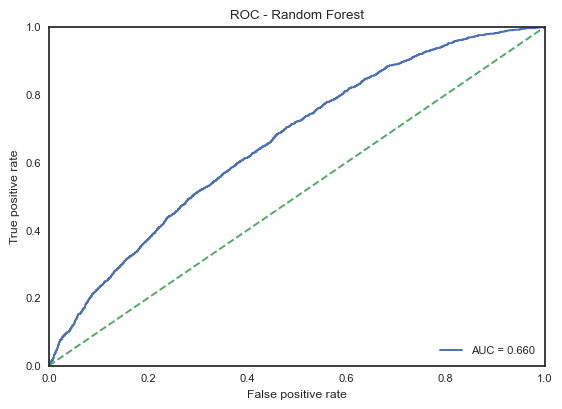

Bootstrap 95% CI for AUC: 0.660 (0.652–0.664)


In [16]:
from utils.eval import ROC, PRC
from utils.stats import bootstrap_ci, estimate_ci
from sklearn import metrics

y_pred = rf_pipe.predict_proba(X_test)

# Plot ROC
rf_roc = ROC(y_test, y_pred)
rf_roc.plot(title='Random Forest')

# Estimate AUC and Bootstrap CIs
rf_roc_auc = bootstrap_ci(stat=ROC.calc_auc, data=(y_test, y_pred), replicates=10)
print(f"Bootstrap 95% CI for AUC: {estimate_ci(rf_roc_auc['stat'], rf_roc_auc['percentile'])}")


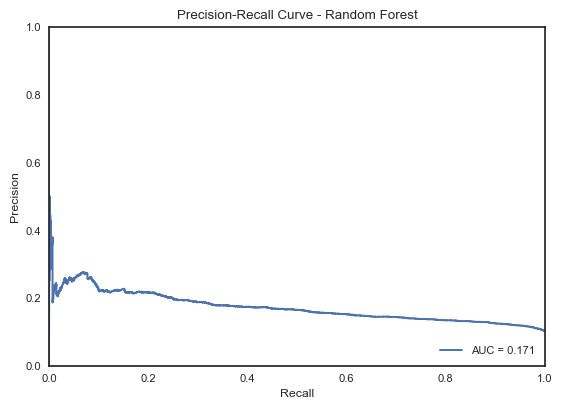

In [17]:
# Plot PRC
rf_prc = PRC(y_test, y_pred)
rf_prc.plot(title='Random Forest')

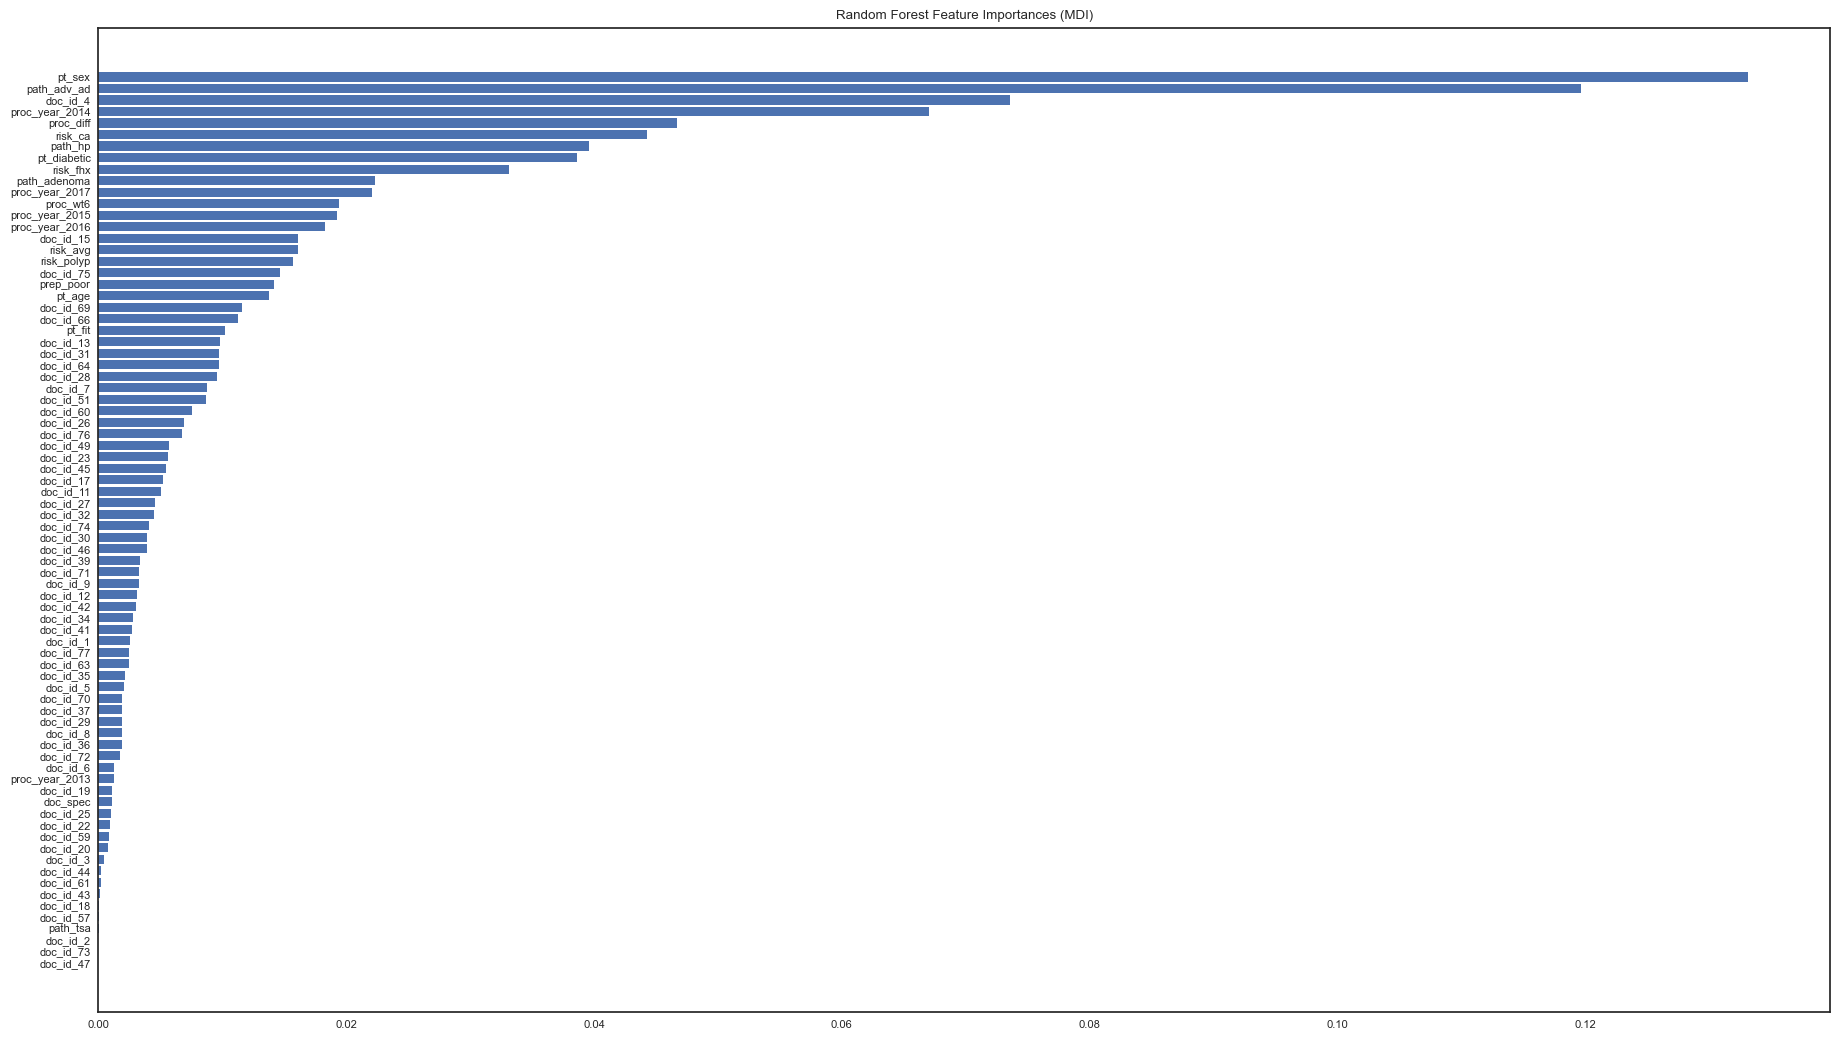

In [39]:
# importances = pd.Series(rf_gs_best.feature_importances_)
# std = np.std([tree.feature_importances_ for tree in rf_gs_best.estimators_], axis=0)
from utils.features import Ftype
def graph_feature_importances(pipe, model, fts, title : str = "Random Forest Feature Importances (MDI)", graph_size: tuple = (18.5, 10.5)):

    if isinstance(model, str): model = pipe.named_steps[model]

    ohe = pipe.named_steps['preprocessor'].named_transformers_['categorical'].named_steps['onehot']
    ft_names = np.r_[fts.lookup(Ftype.dichotomous), ohe.get_feature_names_out(fts.lookup(Ftype.categorical)), fts.lookup(Ftype.continuous)]

    tree_feature_importances = model.feature_importances_
    sorted_idx = tree_feature_importances.argsort()

    y_ticks = np.arange(0, len(ft_names))
    fig, ax = plt.subplots()
    fig.set_size_inches(*graph_size)
    ax.barh(y_ticks, tree_feature_importances[sorted_idx])
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(ft_names[sorted_idx])
    ax.set_title(title)
    fig.tight_layout()
    plt.show()


graph_feature_importances(rf_pipe, 'rf', fts)


In [20]:
from utils.eval import PermutationImportance

# pi_scoring = ['accuracy', 'balanced_accuracy', 'f1', 'roc_auc']
pi_scoring = ['roc_auc']
rf_pi = PermutationImportance(rf_pipe, X_train, y_train, n_repeats = 10, scoring = pi_scoring)

roc_auc


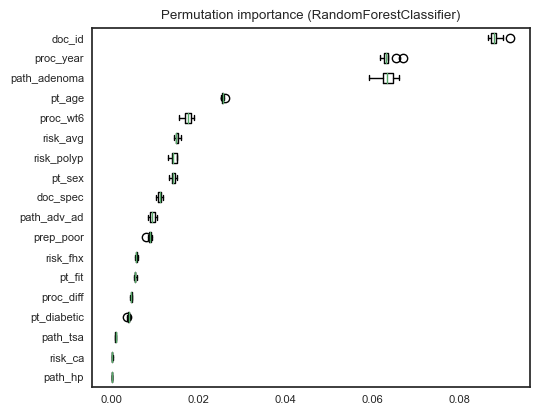

In [21]:
rf_pi.graph()

## Xgboost

In [22]:
import xgboost as xgb

xbp_params_init = dict(
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    nthread=4,
    scale_pos_weight=1,
    seed=42,
  )

xgb_pipe = Pipeline([
  ('preprocessor', preprocessor(fts)),
  ('xgb', xgb.XGBClassifier(**xbp_params_init))
], verbose=True)

xgb_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('continuous',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['pt_age']),
                                                 ('dichotomous',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['pt_sex', 'pt_diabetic',
                                                   'pt_fit', 'risk_avg',
                                                   'risk_fhx', 'risk_polyp',
                                                   'risk_ca', 'doc_spec',
                                                   'proc_wt6', 'pro...
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=1, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, nthread=4, num_parallel_tree=None,
                               predictor=None, random_state=None,
                               reg_alpha=None, reg_lambda=None,
                               scale_pos_weight=1, seed=42, subsample=0.8,
                               tree_method=None, use_label_encoder=False, ...))],
         verbose=True)

In [23]:
from sklearn.model_selection import GridSearchCV
from utils.model_persistence import model_load, model_save

xgb_param_grid = {
 'xgb__max_depth': range(3, 10, 2),
 'xgb__min_child_weight': range(1, 6, 2),
 'xgb__subsample': [i/10.0 for i in range(6, 10)],
 'xgb__colsample_bytree': [i/10.0 for i in range(6,10)],
 'xgb__gamma': [i/10.0 for i in range(0,5)],
 'xgb__learning_rate': [0.1, 0.3, 0.5, 1],
 'xgb__n_estimators': [50, 100, 250, 500, 1000],
 'xgb__reg_alpha': [1e-5, 1e-2, .1, 1, 100],
}

gs_strategy = [
    ['xgb__learning_rate', 'xgb__n_estimators'],
    ['xgb__max_depth', 'xgb__min_child_weight'],
    ['xgb__gamma'],
    ['xgb__subsample', 'xgb__colsample_bytree'],
]


def run_xgb_gs(xgb_pipe, gs_strategy, xgb_param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=3):
    xgb_gs_results = []

    for params in gs_strategy:
        xgb_gs = GridSearchCV(
            xgb_pipe, {k: xgb_param_grid[k] for k in params}, cv=cv, scoring=scoring, n_jobs=n_jobs, verbose=verbose
        ).fit(X_train, y_train_1d)

        # Update pipe with best parameters
        xgb_pipe.set_params(**xgb_gs.best_params_)
        xgb_gs_results.append(xgb_gs)

    # Best model parameters from grid search
    print(list(gs.best_params_ for gs in xgb_gs_results))
    print(xgb_pipe.named_steps['xgb'].get_params())


    # Train model on entire training dataset
    xgb_pipe.fit(X_train, y_train_1d)

    return xgb_pipe

# xgb_pipe = run_xgb_gs(xgb_pipe, gs_strategy, xgb_param_grid)
# model_save(xgb_pipe, 'ssl-xgb-upsampled.joblib')

xgb_pipe = model_load(f'{exp_name}-XGBClassifier.joblib')

In [24]:
from utils.eval import pretty_print_params

pretty_print_params(xgb_pipe[-1], params=['learning_rate', 'n_estimators', 'max_depth', 'min_child_weight', 'gamma', 'subsample', 'colsample_bytree',])

'learning_rate: 0.1, n_estimators: 100, max_depth: 5, min_child_weight: 3, gamma: 0.0, subsample: 0.6, colsample_bytree: 0.6'

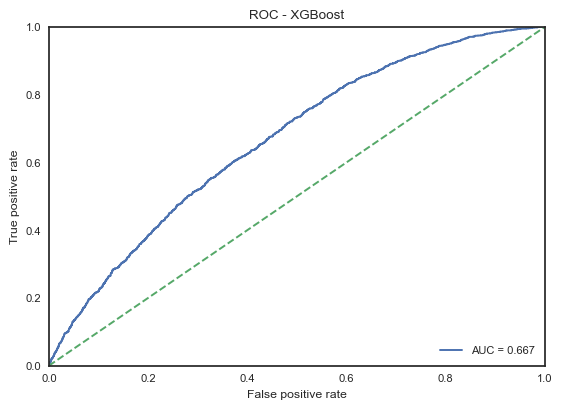

Bootstrap 95% CI for AUC: 0.667 (0.657–0.672)


In [25]:
from utils.eval import ROC, PRC
from utils.stats import bootstrap_ci, estimate_ci

y_pred = xgb_pipe.predict_proba(X_test)

# Plot ROC
xgb_roc = ROC(y_test, y_pred)
xgb_roc.plot(title='XGBoost')

# Estimate AUC and Bootstrap CIs
xgb_roc_auc = bootstrap_ci(stat=ROC.calc_auc, data=(y_test, y_pred), replicates=10)
print(f"Bootstrap 95% CI for AUC: {estimate_ci(xgb_roc_auc['stat'], xgb_roc_auc['percentile'])}")

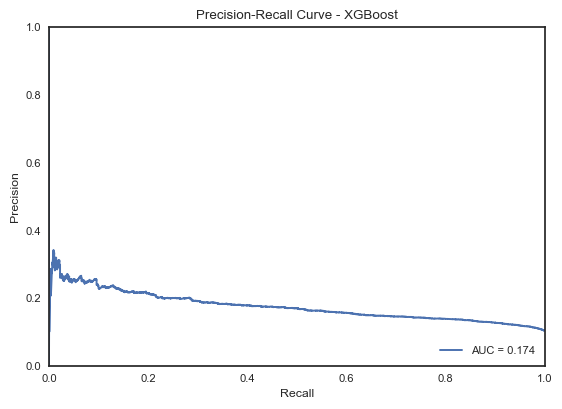

Bootstrap 95% CI for AUC: 0.667 (0.658–0.678)


In [26]:
# Plot PRC
xgb_prc = PRC(y_test, y_pred)
xgb_prc.plot(title='XGBoost')

# Estimate AUC and Bootstrap CIs
xgb_prc_auc = bootstrap_ci(stat=ROC.calc_auc, data=(y_test, y_pred), replicates=10)
print(f"Bootstrap 95% CI for AUC: {estimate_ci(xgb_prc_auc['stat'], xgb_prc_auc['percentile'])}")

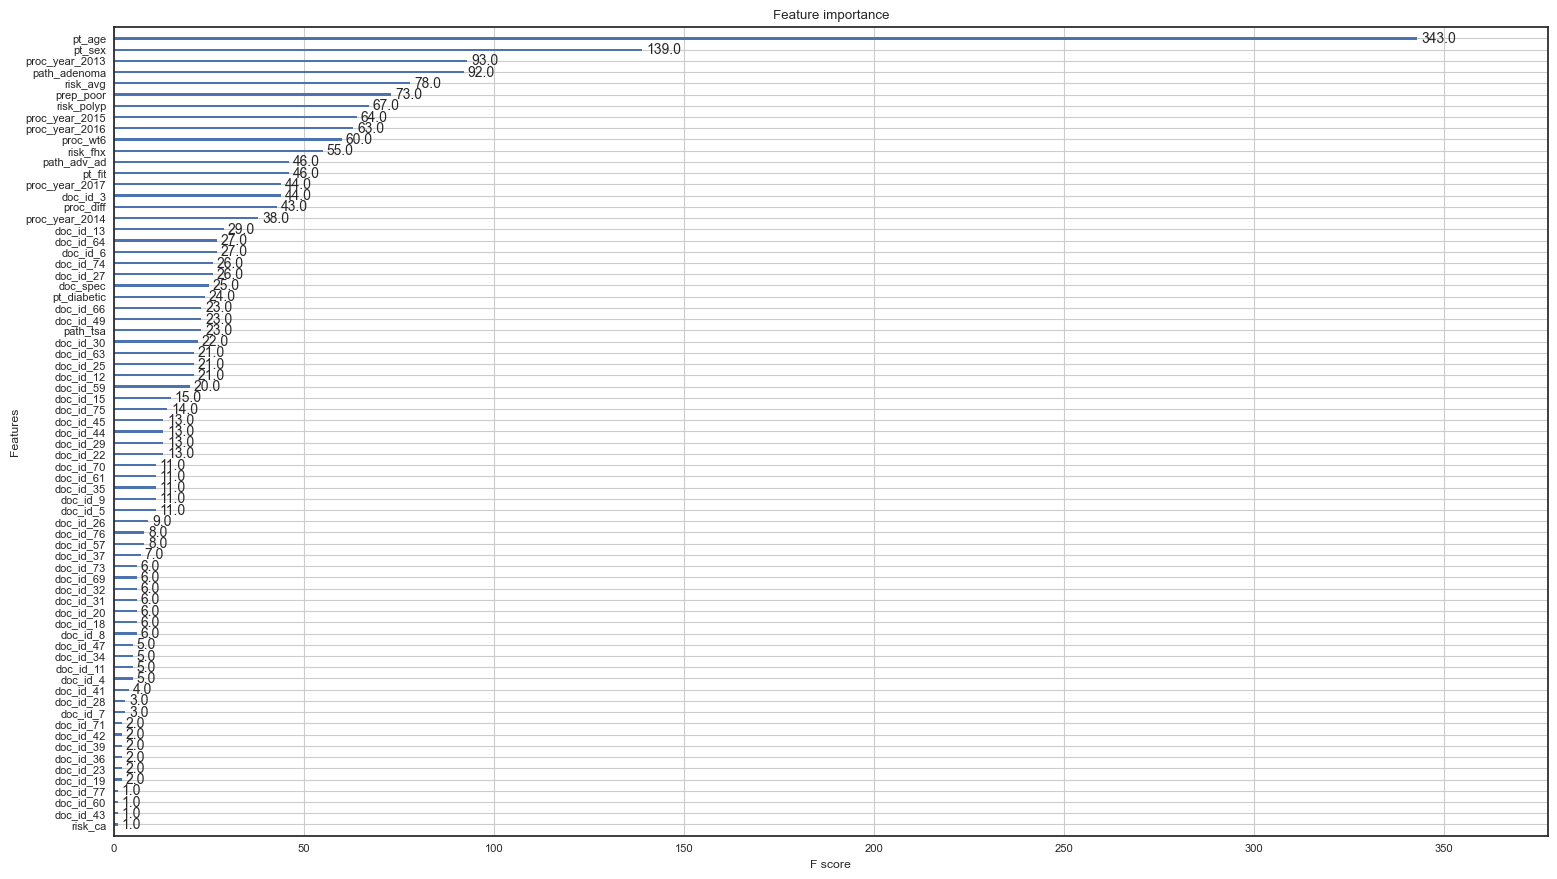

In [27]:
from utils.eval import get_feature_names

xgb_model = xgb_pipe._final_estimator.get_booster()
xgb_model.feature_names = get_feature_names(xgb_pipe)

ax = xgb.plot_importance(xgb_model)
fig = ax.figure
fig.set_size_inches((18.5,10.5))
plt.show()

In [28]:
from utils.eval import PermutationImportance

xgb_pi = PermutationImportance(xgb_pipe, X_train, y_train, n_repeats = 10, scoring = ['roc_auc'])

roc_auc


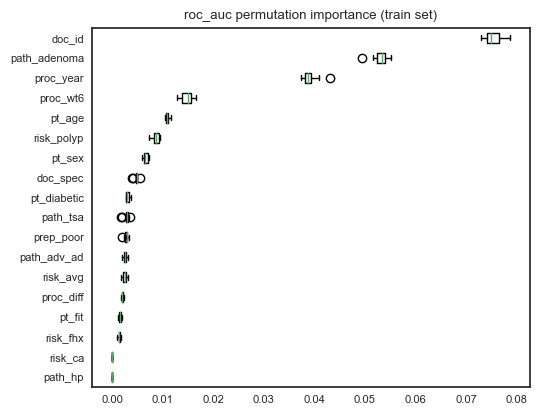

In [29]:
xgb_pi.graph(f_title = lambda scoring: f"{scoring} permutation importance (train set)")

## MLP

In [30]:
from sklearn.neural_network import MLPClassifier
from utils.model_persistence import model_load, model_save

mlp_pipe = Pipeline([
  ('preprocessor', preprocessor(fts)),
  ('mlp', MLPClassifier(max_iter=2500))
], verbose=True)

def run_mlp_gs(mlp_pipe):

  mlp_param_grid = {
    'mlp__hidden_layer_sizes': [(25, 10, 10),(50, 25, 25),(100, 50, 25)],
    'mlp__activation': ['tanh', 'relu'],
    'mlp__solver': ['adam'],
    'mlp__alpha': [1e-4],
    'mlp__learning_rate': ['adaptive'],
  }

  return GridSearchCV(mlp_pipe, mlp_param_grid, scoring='roc_auc', cv=3, n_jobs=-1).fit(
    X_train, y_train.values.ravel(),
  )

# mlp_gs = run_mlp_gs(mlp_pipe)
# mlp_pipe = mlp_gs.best_estimator_
# model_save(mlp_pipe, f'{exp_name}-MLPClassifier.joblib')

mlp_pipe = model_load(f'{exp_name}-MLPClassifier.joblib')

In [31]:
mlp_pipe._final_estimator.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (25, 10, 10),
 'learning_rate': 'adaptive',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 2500,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

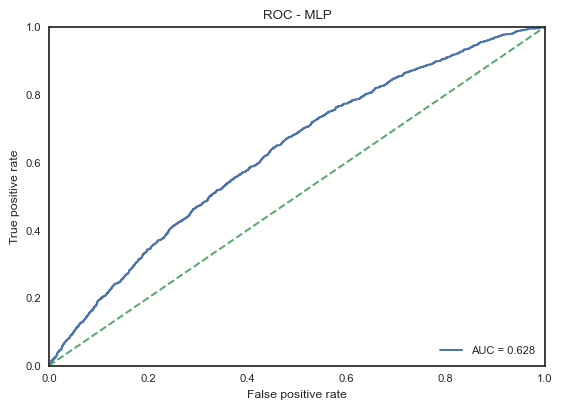

Bootstrap 95% CI for AUC: 0.628 (0.618–0.631)


In [32]:
from utils.eval import ROC, PRC
from utils.stats import bootstrap_ci, estimate_ci

y_pred = mlp_pipe.predict_proba(X_test)

# Plot ROC
xgb_roc = ROC(y_test, y_pred)
xgb_roc.plot(title='MLP')

# Estimate AUC and Bootstrap CIs
mlp_roc_auc = bootstrap_ci(stat=ROC.calc_auc, data=(y_test, y_pred), replicates=10)
print(f"Bootstrap 95% CI for AUC: {estimate_ci(mlp_roc_auc['stat'], mlp_roc_auc['percentile'])}")

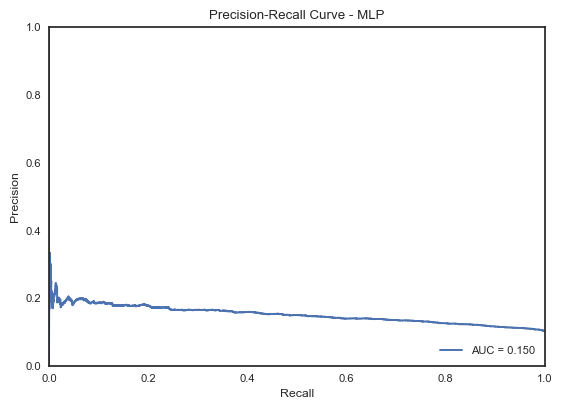

Bootstrap 95% CI for AUC: 0.628 (0.614–0.634)


In [33]:
# Plot PRC
mlp_prc = PRC(y_test, y_pred)
mlp_prc.plot(title='MLP')

# Estimate AUC and Bootstrap CIs
mlp_prc_auc = bootstrap_ci(stat=ROC.calc_auc, data=(y_test, y_pred), replicates=10)
print(f"Bootstrap 95% CI for AUC: {estimate_ci(mlp_prc_auc['stat'], mlp_prc_auc['percentile'])}")

In [34]:
from utils.eval import PermutationImportance

pi_scoring = ['roc_auc']
mlp_pi = PermutationImportance(mlp_pipe, X_train, y_train, n_repeats = 10, scoring = pi_scoring)

roc_auc


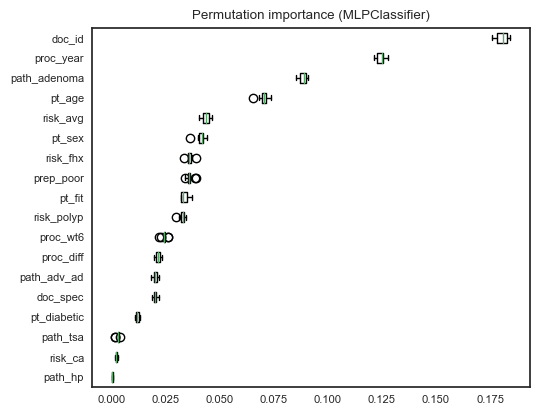

In [35]:
mlp_pi.graph()

## Model Eval

In [36]:
clfs = [rf_pipe, xgb_pipe, mlp_pipe, dummy_pipe]

### Calibration Plots

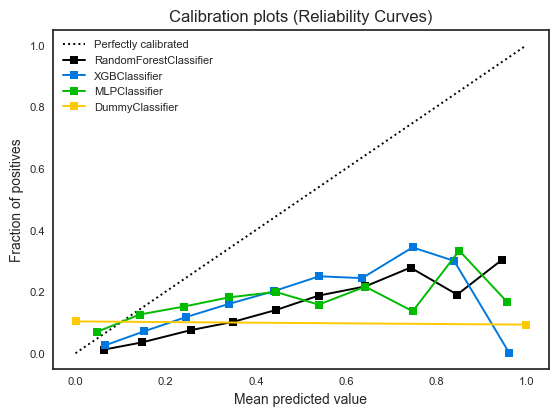

In [37]:
import scikitplot as skplt

skplt.metrics.plot_calibration_curve(
    np.asarray(y_test).ravel(),
    [clf.predict_proba(X_test) for clf in clfs],
    [clf[-1].__class__.__name__ for clf in clfs],
)
plt.legend(loc='upper left')
plt.show()

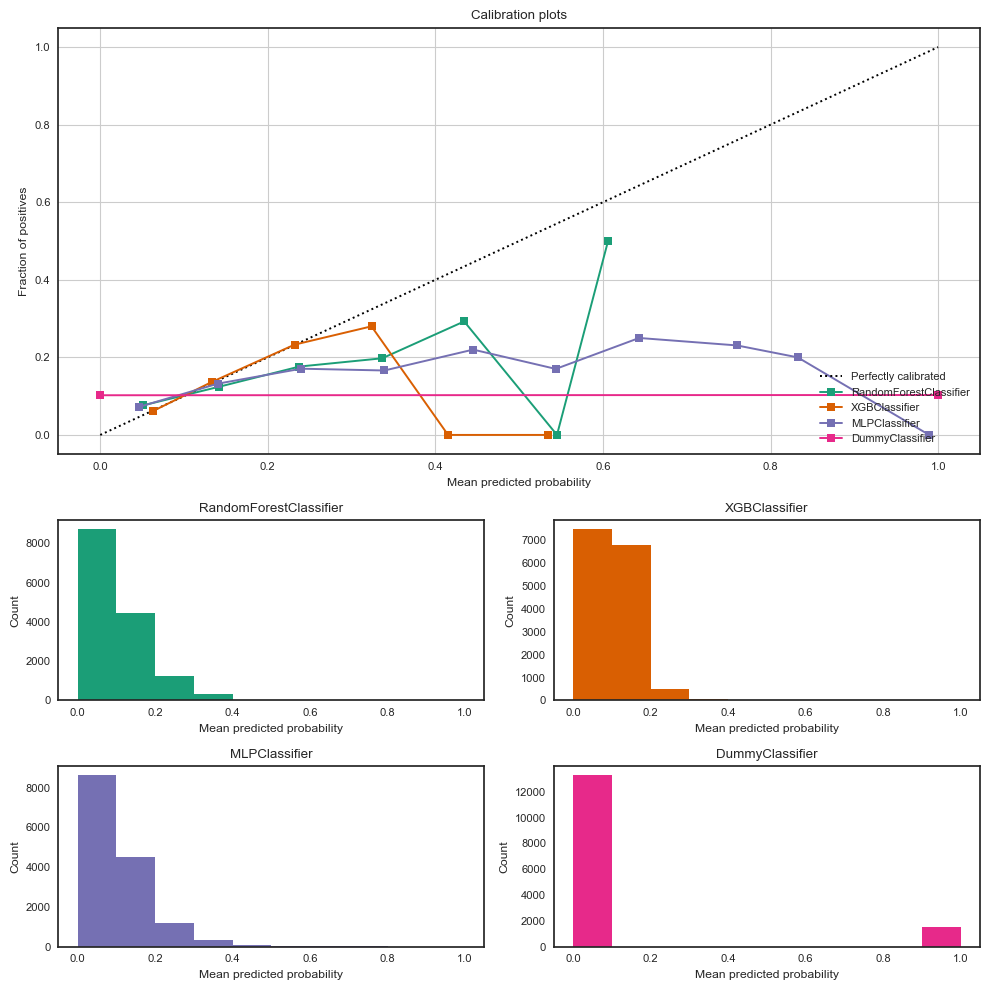

In [149]:
from sklearn.calibration import CalibrationDisplay
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, clf in enumerate(clfs):
    # clf.fit(X_train, y_train)
    name = clf[-1].__class__.__name__
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, clf in enumerate(clfs):
    name = clf[-1].__class__.__name__
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=clf.__class__.__name__,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

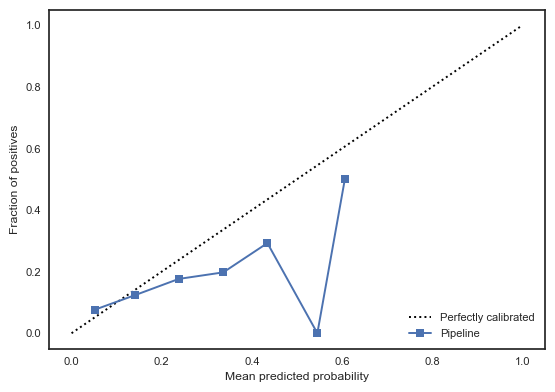

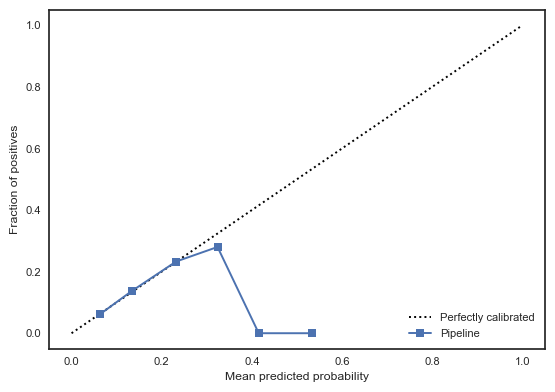

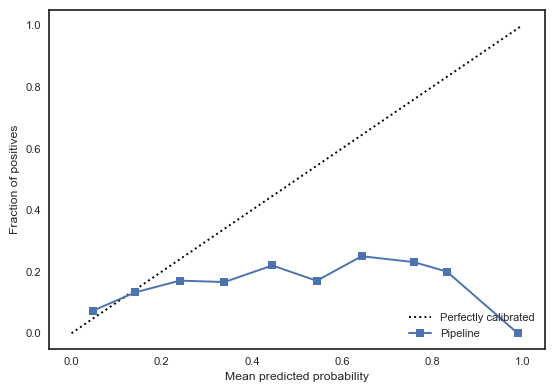

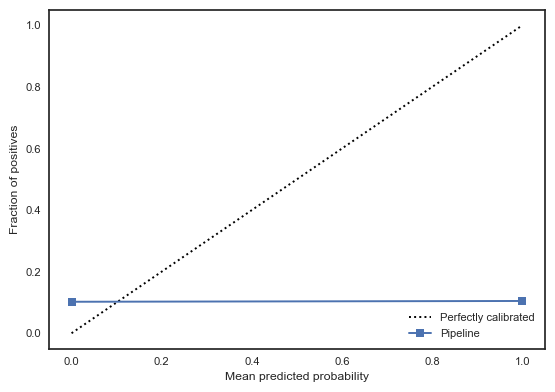

In [146]:
for clf in clfs:
    CalibrationDisplay.from_estimator(
        clf, X_test, y_test, n_bins=10
    )
    plt.show()

In [53]:
from sklearn import metrics

model = clfs[0]

# y_pred = model.predict_proba(X_test)
y_pred = model.predict(X_test)

# model_auc = bootstrap_ci(stat=ROC.calc_auc, data=(y_test, y_pred), replicates=10)
# print(f"Bootstrap 95% CI for AUC: {estimate_ci(model_auc['stat'], model_auc['percentile'])}")

model_precision = bootstrap_ci(stat=metrics.precision_score, data=(y_test, y_pred), replicates=5)
print(f"Bootstrap 95% CI for Precision: {estimate_ci(model_precision['stat'], model_precision['percentile'])}")

Bootstrap 95% CI for Precision: 0.200 (0.000, 0.329)


In [38]:
from utils.stats import bootstrap_ci, get_bootstrap_data, bootstrap_estimate
from utils.eval import calc_specificity
from sklearn import metrics

def calc_classification_metrics(clfs, X_test, y_test, threshold = 0.5, bootstrap_replicates = 100) -> pd.DataFrame:

    confusion_metrics = {
        'Sensitivity': metrics.recall_score,
        'Specificity': calc_specificity,
        'Accuracy': metrics.accuracy_score,
        'Balanced Accuracy': metrics.balanced_accuracy_score,
        'F1 score': metrics.f1_score,
    }

    model_probs = [clf.predict_proba(X_test) for clf in clfs]
    model_preds = [(proba[:,1] > threshold).astype(float) for proba in model_probs]

    bootstrap_datasets = [get_bootstrap_data((y_test, y_pred), bootstrap_replicates) for y_pred in model_preds]

    def get_bootstrap_ci(bootstrap_estimate):
        return estimate_ci(bootstrap_estimate['stat'], bootstrap_estimate['percentile']).__str__()

    df_metrics = pd.DataFrame({
        metric: [get_bootstrap_ci(bootstrap_estimate(calc, *B)) for B in bootstrap_datasets] for (metric, calc) in confusion_metrics.items()
        })

    roc_metrics = []
    prc_metrics = []

    for y_pred in model_probs:

        model_roc_auc = bootstrap_ci(stat=ROC.calc_auc, data=(y_test, y_pred), replicates=bootstrap_replicates)
        roc_metrics.append(estimate_ci(model_roc_auc['stat'], model_roc_auc['percentile']).__str__())

        model_prc_auc = bootstrap_ci(stat=PRC.calc_auc, data=(y_test, y_pred), replicates=bootstrap_replicates)
        prc_metrics.append(estimate_ci(model_prc_auc['stat'], model_prc_auc['percentile']).__str__())

    df_metrics['ROC-AUC'] = roc_metrics
    df_metrics['PRC-AUC'] = prc_metrics

    df_metrics['Model'] = [clf[-1].__class__.__name__ for clf in clfs]
    df_metrics.set_index('Model', inplace=True)
    
    return df_metrics

def print_classification_metrics():

    # choose threshold to be the mean of training data
    threshold = y_train_1d.mean()

    # 100 bootstrap replicates for estimating accuracy metrics
    replicates = 100
    df_metrics = calc_classification_metrics(clfs, X_test, y_test, threshold=threshold, bootstrap_replicates=replicates)

    # print table
    print(f"Classification accuracy table (threshold={threshold:.3f}, bootstrap replicates={replicates})")
    return df_metrics

print_classification_metrics()

Classification accuracy table (threshold=0.102, bootstrap replicates=100)


,Sensitivity,Specificity,Accuracy,Balanced Accuracy,F1 score,ROC-AUC,PRC-AUC
Model,,,,,,,
RandomForestClassifier,0.694 (0.665–0.719),0.527 (0.520–0.536),0.544 (0.537–0.553),0.610 (0.595–0.623),0.238 (0.223–0.252),0.660 (0.648–0.673),0.171 (0.159–0.185)
XGBClassifier,0.669 (0.645–0.689),0.559 (0.553–0.567),0.570 (0.564–0.578),0.614 (0.602–0.626),0.242 (0.231–0.252),0.667 (0.655–0.677),0.174 (0.159–0.186)
MLPClassifier,0.565 (0.542–0.593),0.614 (0.607–0.621),0.609 (0.602–0.617),0.590 (0.577–0.604),0.228 (0.218–0.242),0.628 (0.613–0.639),0.150 (0.139–0.159)
DummyClassifier,0.115 (0.102–0.129),0.900 (0.895–0.904),0.820 (0.814–0.825),0.508 (0.501–0.515),0.116 (0.103–0.130),0.508 (0.499–0.516),0.161 (0.146–0.179)
